<a href="https://colab.research.google.com/github/FilipeBarnabe/cv_assign1/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
by:\
Filipe Barnabé - 202109213,\
João Ferreira - 202103619

In [1]:
!git clone https://github.com/FilipeBarnabe/cv_assign1.git

Cloning into 'cv_assign1'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.
Checking out files: 100% (49/49), done.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from os import listdir, path
from statistics import mean

In [3]:
folder_int = r'cv_assign1/IntrinsicCalibration'
folder_wht = r'cv_assign1/WhiteBackground'
folder_gry = r'cv_assign1/GreyBackground'

# General Functions

## Region of Interest

In [4]:
def roi(img):
    return img[0:700, 250:1350]

## Translation of pixels to mm

In [5]:
def area_add_mm(area:dict, px_mm) -> dict:
    for key, value in area.items():
        area[key] = [value, round((value*px_mm),2)]
    return area

## Detection of the colors: the four colors for the m&m's and the addition of black for the extrinsic calibration

In [6]:
def detect_color(mask, hsv, color: list, color_selected: str, image: np.ndarray, ratio):

    res = cv2.bitwise_and(hsv, hsv, mask=mask)
    res = cv2.cvtColor(cv2.cvtColor(res, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(res) 
    res = cv2.erode(res, None, iterations=3)
    res = cv2.dilate(res, None, iterations=4)
    newImage = image
    contours, _ = cv2.findContours(res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    counter = 0
    area = {}
    square_area = []

    if color_selected != "black":
        for cnt in contours:
            (x,y),radius = cv2.minEnclosingCircle(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            if(radius > 20):
                counter += 1
                cv2.rectangle(newImage,(x,y),(x+w,y+h),color,2)
                area[counter] = cv2.contourArea(cnt)
                cv2.putText(newImage, str(counter), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                
        area = area_add_mm(area, ratio)
        return newImage, counter, area
        
    else:
        cv2.drawContours(newImage, contours, -1, (0, 255, 0), 2)
        for cnt in contours:
            (x,y),radius = cv2.minEnclosingCircle(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            if(radius > 40):
                counter += 1
                area[counter] = cv2.contourArea(cnt)
                square_area.append(w*h)
                cv2.putText(newImage, f"w: {w}, h: {h}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
        return newImage, counter, area, square_area

## Creation of the mask for the selection of colors

In [7]:
def select_color(image: np.ndarray, color, ratio=None):
    """
    color blue = 1 \n
    color yeallow = 2 \n
    color red = 3 \n
    color green = 4 \n
    color black = 5 \n
    """

    if color == 1:
        lower = [90, 90, 70]#[100,128,0]
        upper = [128, 255, 255]#[215,255,255]
        box_text_color = [255, 0, 0]
        color_selected = "blue"
        lower_range = np.array(lower, np.uint8)
        upper_range = np.array(upper, np.uint8)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.GaussianBlur(hsv, (11, 11), 0)
        mask = cv2.inRange(mask, lower_range, upper_range)
    
    elif color == 2:
        lower = [15, 90, 0]#[22, 93, 0]
        upper = [45, 255, 255]#[45, 255, 255]
        box_text_color = [0, 255, 255]
        color_selected = "yellow"
        lower_range = np.array(lower, np.uint8)
        upper_range = np.array(upper, np.uint8)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.GaussianBlur(hsv, (11, 11), 0)
        mask = cv2.inRange(mask, lower_range, upper_range)

    elif color == 3:
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # lower mask (0-10)
        lower_red = np.array([0,100,50])
        upper_red = np.array([10,255,255])
        mask0 = cv2.inRange(hsv, lower_red, upper_red)

        # upper mask (170-180)
        lower_red = np.array([170,50,50])
        upper_red = np.array([180,255,255])
        mask1 = cv2.inRange(hsv, lower_red, upper_red)

        # join my masks
        mask = mask0+mask1
        box_text_color = [0, 0, 255]
        color_selected = "red"
        
    elif color == 4:
        lower = [36, 50, 50]#[55,0,10]
        upper = [100, 255, 255]#[86,255,255]
        box_text_color = [0, 255, 0]
        color_selected = "red"
        lower_range = np.array(lower, np.uint8)
        upper_range = np.array(upper, np.uint8)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.GaussianBlur(hsv, (11, 11), 0)
        mask = cv2.inRange(mask, lower_range, upper_range)    
        
    elif color == 5:
        lower = [0, 0, 0]#[55,0,10]
        upper = [360, 255, 50]#[86,255,255]
        box_text_color = [0, 255, 0]
        color_selected = "black"
        lower_range = np.array(lower, np.uint8)
        upper_range = np.array(upper, np.uint8)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.GaussianBlur(hsv, (11, 11), 0)
        mask = cv2.inRange(mask, lower_range, upper_range)

    return detect_color(mask=mask, hsv=hsv, color=box_text_color, image=image, color_selected=color_selected, ratio=ratio)

# Intrinsic Calibration

### Find and identify Chessboard Corners from calibration dataset

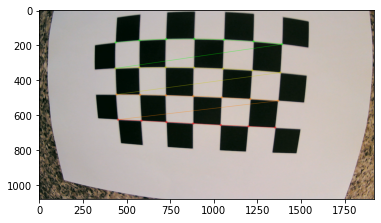

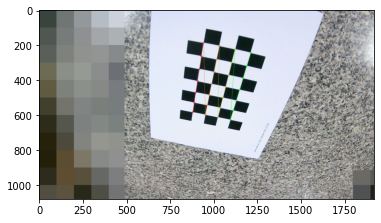

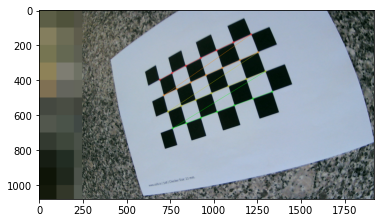

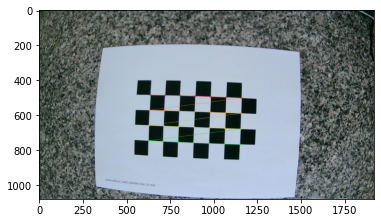

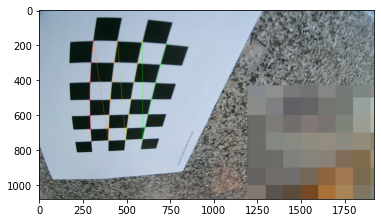

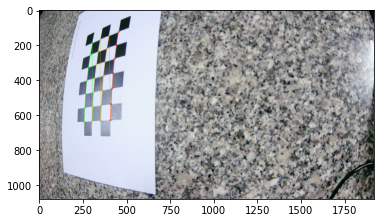

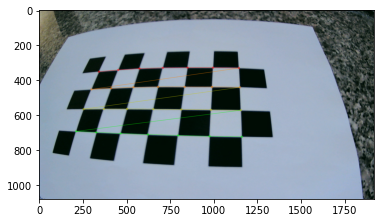

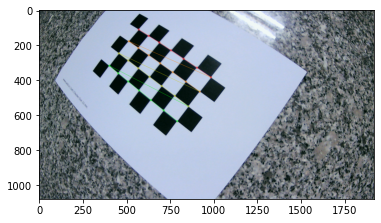

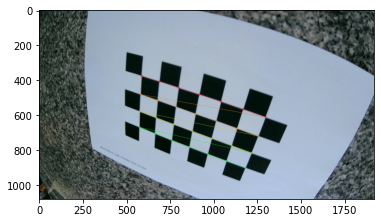

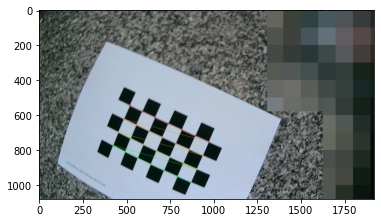

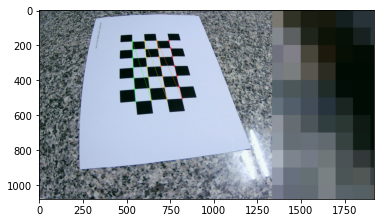

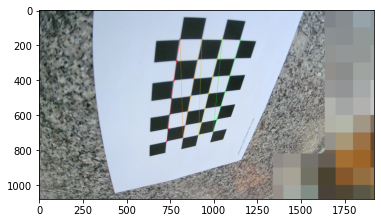

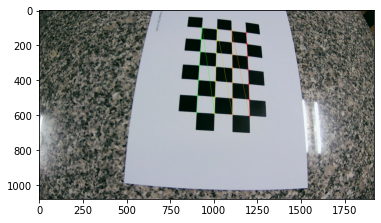

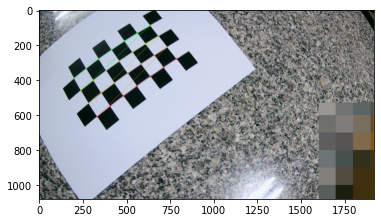

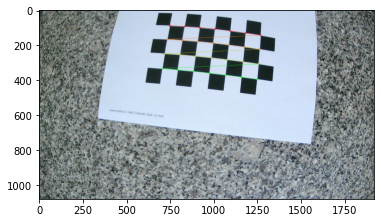

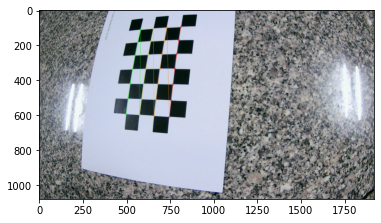

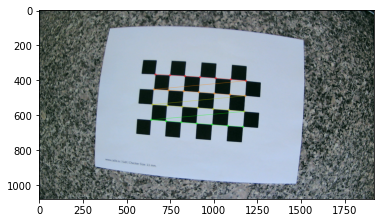

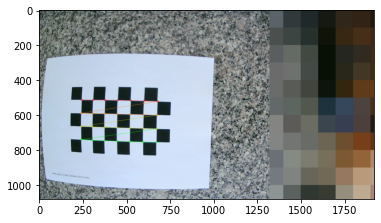

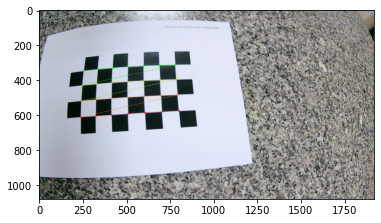

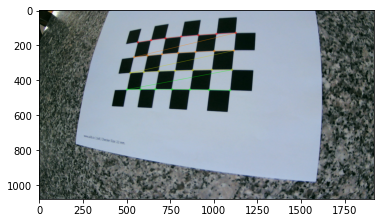

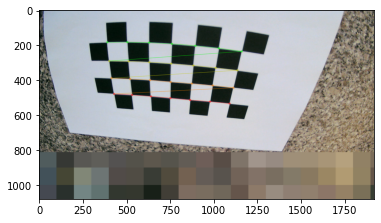

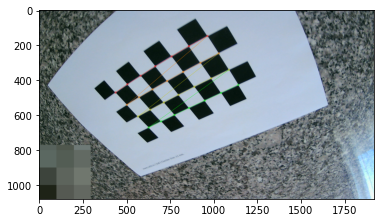

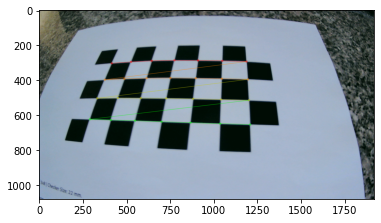

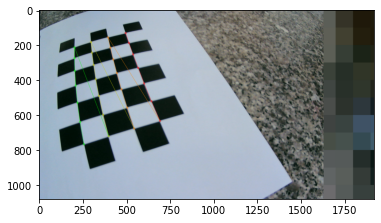

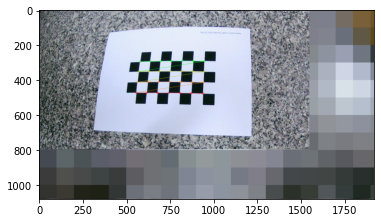

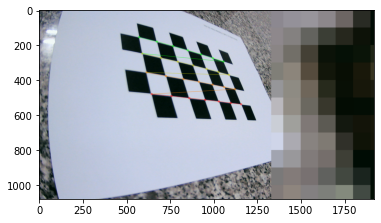

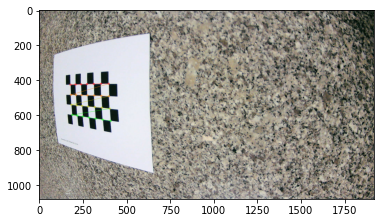

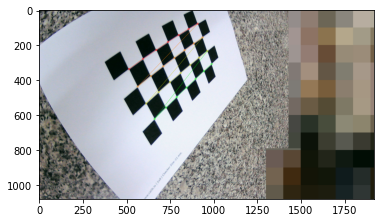

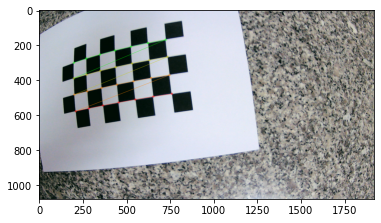

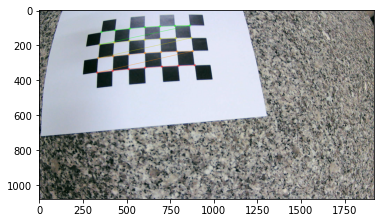

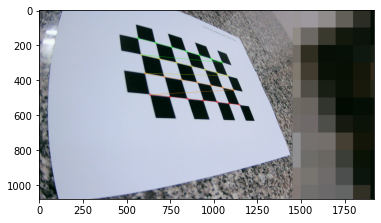

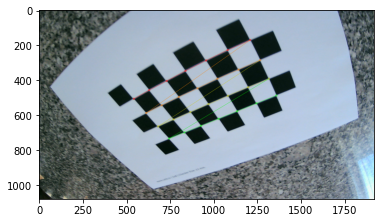

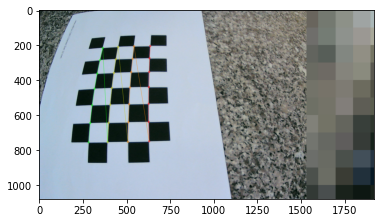

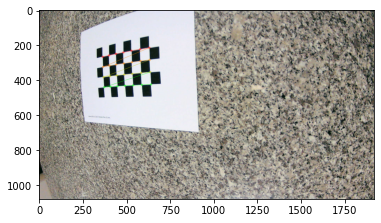

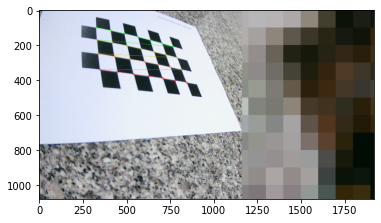

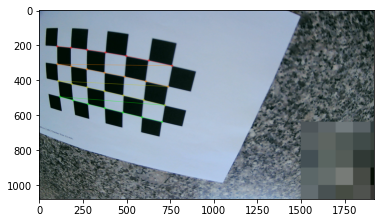

In [8]:
# Information about the chessboard: 5x8 squares and size of a square = 21mm 
# Information about the chessboard: 4x7 internal corners 
tabuleiro = (7, 4)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Defining the world coordinates for 3D points
objp = np.zeros((1, tabuleiro[0] * tabuleiro[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:tabuleiro[0], 0:tabuleiro[1]].T.reshape(-1, 2)

images_int_calib = glob.glob(folder_int +'/*.png')

for fname in images_int_calib:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (tabuleiro[0], tabuleiro[1]), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw the internal corners
        cv2.drawChessboardCorners(img, (tabuleiro[0], tabuleiro[1]), corners2, ret)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

### Calibrate the camera and return the camera matrix, distrotion coefficients, rotation and translation vectors

In [9]:
_, cam_mtx, distortion_coeffs, rotation_vecs, translation_vecs =\
    cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Intrinsic_camera_matrix = cam_mtx\
Lens_distortion_coefficients = distortion_coeffs\
Rotation_vector_3x1 = rotation_vecs\
    The direction of the vector specifies the axis of rotation and the magnitude of the vector specifies the angle of rotation.\
Translation_vector_3x1 = translation_vecs

ret = retval -> will be True if pattern is obtained\
cam_mtx -> camera matrix\
distortion_coeffs -> distortion coefficients per image\
rotation_vecs -> rotation vectors per image\
translation_vecs -> translation vectors per image

### Undistortion
http://blog.nishihara.me/opencv/2015/09/03/how-to-improve-opencv-performance-on-lens-undistortion-from-a-video-feed/

In [10]:
def undistort_img(img):

    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cam_mtx, distortion_coeffs, (w,h), 1, (w,h))

    # From the gathered information, the following undistorting method is faster to run cyclicly than to use cv2.undidstort function

    # undistorting
    mapx, mapy = cv2.initUndistortRectifyMap(cam_mtx, distortion_coeffs, None, newcameramtx, (w,h), 5)

    # remapping
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w] # Resulting Undistorted image (cropped by Region Of Interest)
    # Here we could store the camera matrix (cam_mtx) and distortion coefficients (dst) (e.g., np.savez, np.savetxt etc) for future uses.

    return dst

### Re-projection Error estimation on thhe calibration image
Re-projection error gives a good estimation of just how exact the found parameters are.\
The closer the re-projection error is to zero, the more accurate the parameters are.

In [11]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rotation_vecs[i], translation_vecs[i], cam_mtx, distortion_coeffs)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.08655252216985405


# Extrinsic Calibration

### Gathering the black square dimensions in pixels

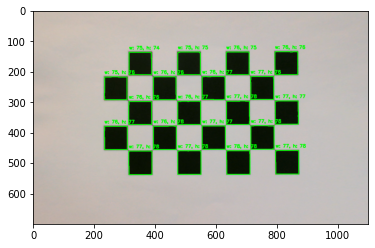

In [12]:
img = cv2.imread(folder_wht + '/extrinsic.png')  # Calibration verification image
img = undistort_img(img)
img = img[0:700, 350:1450]
img, counter, area, square_area = select_color(img, 5)
plt.imshow(img)

### Calculating the conversion between pixels and milimeters

In [13]:
# black square area in milimeters
square_area_mm = 21*21

# the best representation of the outline of the black squares is coincidentially,
# the largest area of a square (image above),  like so, this method was used
# to retrieve the area of the black square in pixels
max_square_area_px = max(square_area)

# Calculation of the ratio between milimeters and pixels
ratio = square_area_mm/max_square_area_px
print(f"There is a ratio of {ratio} mm^2 per pixel")

There is a ratio of 0.07248520710059171 mm^2 per pixel


# Image Procesing

## Determinates the pixel area

In [14]:
def area_to_pix_area(area: dict) -> np.array:
    area_px = []
    for value in area.values():
        area_px.append(value)
    return np.array(area_px)

## Calculations for the number of bins and number if elements in each bin fot de destribution histogram 

In [15]:
def area_hist(area: dict):
    return np.histogram(area_to_pix_area(area))

## Detection of peanuts by color for the respective images

In [16]:
def identify_peanuts(image, color_code, color_str,ratio):

    image, counter, area = select_color(image.copy(), color_code, ratio=ratio)
    counts, bins = area_hist(area)
    
    avg_px_list = []
    avg_mm_list = []

    print(f"\nNumber of {color_str} m&m's: {counter}")
    for key, value in area.items():
        print(f"The m&m {key} has {value[0]} pixels and its area corresponds to {value[1]} mm^2 ")
        avg_px_list.append(value[0])
        avg_mm_list.append(value[1])
    
    print(f"The average area in pixels is {round(mean(avg_px_list), 2)} and {round(mean(avg_mm_list), 2)} mm^2")

    fig, (ax1, ax2) = plt.subplots(1,2)
    
    fig.suptitle(f"For the color {color_str}")
    ax1.hist(bins[:-1], bins, weights=counts, facecolor=color_str)
    ax1.grid(linestyle="--")
    ax1.set_ylabel("Number of Peanuts")
    ax1.set_xlabel("Area in pixels")
    ax1.set_title("Histogram of shape areas")
    asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
    ax1.set_aspect(asp)
    ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.show()

## Undistorts the image and provides the information for the plot and the necesseary colors

In [17]:
def problem_solver(image, color_code, ratio):
    image = undistort_img(image)
    image = roi(image)
    for key, value in color_code.items():
        identify_peanuts(image, key, value, ratio)

## creates a dict for each image with colors that it is sposed to analyse 

In [18]:
images = glob.glob(folder_wht +'/*.png')
images.sort()

peanut_colors = [
    {},
    {1: "blue", 2: "yellow"},
    {1: "blue", 2: "yellow", 3: "red"},
    {1: "blue", 2: "yellow", 3: "red", 4: "green"},
    {}
]

images_peanut = {}
for i, p in zip(images, peanut_colors):
    images_peanut[i] = p

## Evaluation of all images


 
For the image cv_assign1/WhiteBackground/calib_img 0.png: 

 
For the image cv_assign1/WhiteBackground/calib_img 1.png: 

Number of blue m&m's: 5
The m&m 1 has 3759.0 pixels and its area corresponds to 272.47 mm^2 
The m&m 2 has 2970.5 pixels and its area corresponds to 215.32 mm^2 
The m&m 3 has 4094.0 pixels and its area corresponds to 296.75 mm^2 
The m&m 4 has 4415.0 pixels and its area corresponds to 320.02 mm^2 
The m&m 5 has 4371.0 pixels and its area corresponds to 316.83 mm^2 
The average area in pixels is 3921.9 and 284.28 mm^2


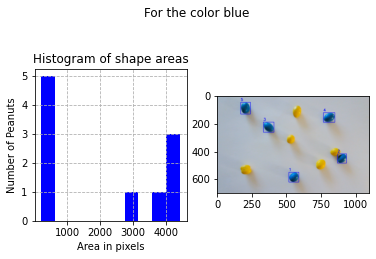


Number of yellow m&m's: 5
The m&m 1 has 5079.0 pixels and its area corresponds to 368.15 mm^2 
The m&m 2 has 4726.0 pixels and its area corresponds to 342.57 mm^2 
The m&m 3 has 3587.0 pixels and its area corresponds to 260.0 mm^2 
The m&m 4 has 3541.0 pixels and its area corresponds to 256.67 mm^2 
The m&m 5 has 4757.0 pixels and its area corresponds to 344.81 mm^2 
The average area in pixels is 4338.0 and 314.44 mm^2


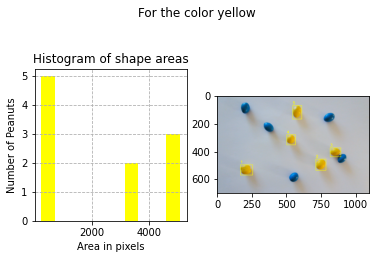


 
For the image cv_assign1/WhiteBackground/calib_img 2.png: 

Number of blue m&m's: 5
The m&m 1 has 3821.5 pixels and its area corresponds to 277.0 mm^2 
The m&m 2 has 3000.0 pixels and its area corresponds to 217.46 mm^2 
The m&m 3 has 3832.5 pixels and its area corresponds to 277.8 mm^2 
The m&m 4 has 4497.5 pixels and its area corresponds to 326.0 mm^2 
The m&m 5 has 4408.5 pixels and its area corresponds to 319.55 mm^2 
The average area in pixels is 3912.0 and 283.56 mm^2


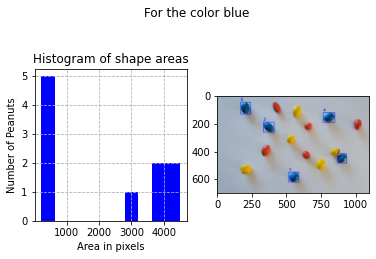


Number of yellow m&m's: 5
The m&m 1 has 4964.0 pixels and its area corresponds to 359.82 mm^2 
The m&m 2 has 4751.0 pixels and its area corresponds to 344.38 mm^2 
The m&m 3 has 3587.5 pixels and its area corresponds to 260.04 mm^2 
The m&m 4 has 3495.5 pixels and its area corresponds to 253.37 mm^2 
The m&m 5 has 4694.0 pixels and its area corresponds to 340.25 mm^2 
The average area in pixels is 4298.4 and 311.57 mm^2


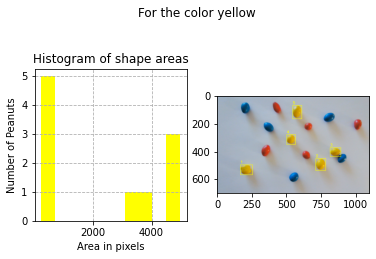


Number of red m&m's: 5
The m&m 1 has 2740.5 pixels and its area corresponds to 198.65 mm^2 
The m&m 2 has 3967.5 pixels and its area corresponds to 287.59 mm^2 
The m&m 3 has 2474.5 pixels and its area corresponds to 179.36 mm^2 
The m&m 4 has 3187.5 pixels and its area corresponds to 231.05 mm^2 
The m&m 5 has 3309.5 pixels and its area corresponds to 239.89 mm^2 
The average area in pixels is 3135.9 and 227.31 mm^2


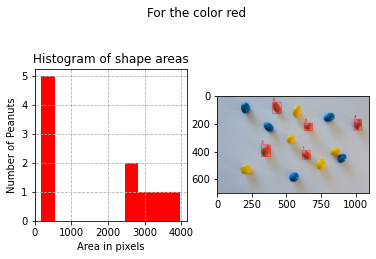


 
For the image cv_assign1/WhiteBackground/calib_img 3.png: 

Number of blue m&m's: 5
The m&m 1 has 3810.0 pixels and its area corresponds to 276.17 mm^2 
The m&m 2 has 3041.5 pixels and its area corresponds to 220.46 mm^2 
The m&m 3 has 4001.5 pixels and its area corresponds to 290.05 mm^2 
The m&m 4 has 4655.5 pixels and its area corresponds to 337.45 mm^2 
The m&m 5 has 4621.0 pixels and its area corresponds to 334.95 mm^2 
The average area in pixels is 4025.9 and 291.82 mm^2


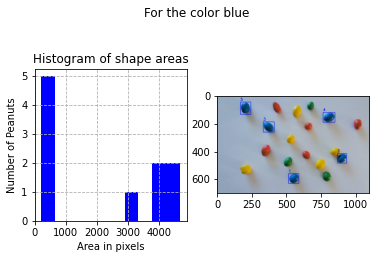


Number of yellow m&m's: 5
The m&m 1 has 4704.5 pixels and its area corresponds to 341.01 mm^2 
The m&m 2 has 4625.0 pixels and its area corresponds to 335.24 mm^2 
The m&m 3 has 3499.0 pixels and its area corresponds to 253.63 mm^2 
The m&m 4 has 3316.0 pixels and its area corresponds to 240.36 mm^2 
The m&m 5 has 4438.0 pixels and its area corresponds to 321.69 mm^2 
The average area in pixels is 4116.5 and 298.39 mm^2


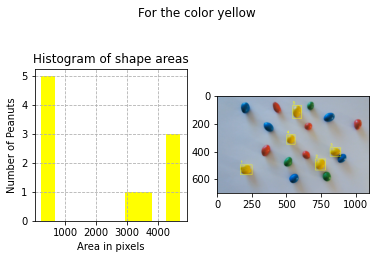


Number of red m&m's: 5
The m&m 1 has 2751.5 pixels and its area corresponds to 199.44 mm^2 
The m&m 2 has 3842.0 pixels and its area corresponds to 278.49 mm^2 
The m&m 3 has 2521.5 pixels and its area corresponds to 182.77 mm^2 
The m&m 4 has 3162.5 pixels and its area corresponds to 229.23 mm^2 
The m&m 5 has 3375.0 pixels and its area corresponds to 244.64 mm^2 
The average area in pixels is 3130.5 and 226.91 mm^2


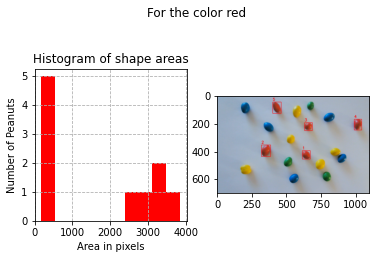


Number of green m&m's: 3
The m&m 1 has 3832.0 pixels and its area corresponds to 277.76 mm^2 
The m&m 2 has 4189.5 pixels and its area corresponds to 303.68 mm^2 
The m&m 3 has 3178.0 pixels and its area corresponds to 230.36 mm^2 
The average area in pixels is 3733.17 and 270.6 mm^2


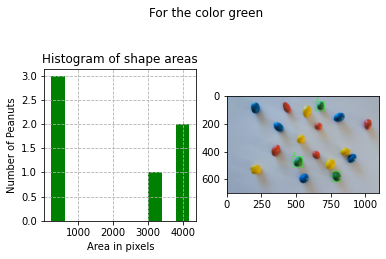


 
For the image cv_assign1/WhiteBackground/extrinsic.png: 


In [19]:
for key, value in images_peanut.items():
    print(f"\n \nFor the image {key}: ")
    image = cv2.imread(key)
    problem_solver(image, value, ratio)

VI. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects).

In order to improve performance of the image processing component, the M&M factory should:
- have a fixed camera angle, pointing vertically straight at the m&ms (e.g., vertical to a conveyor belt)
- take the lightning in consideration, as adding more light sources in order to reduce or eliminate shadows, since these difficult the process;
- apply a physical filter to the camera lens so that the reflections are reduced to a minimum.
- Could also be considered, the use of low and high pass filters in order to aid the image processing stage (blurring & sharpening)